Code necessary for plotting 2D-E

In [1]:
### imports
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import glob
import os
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
### functions
def makefolder(path):
    """Creates folder if it does not exist"""
    if not os.path.exists(path):
        os.makedirs(path)

def runSVM_onetimepoint(frvalues, labels):
    """Run SVM"""
    X = frvalues
    y = labels
    skf1 = StratifiedKFold(n_splits=5, shuffle=True)
    svc = svm.SVC(kernel='linear')

    ypred = np.zeros(y.shape)

    for trainidx, testidx in skf1.split(X, y):
        scaler = StandardScaler()
        Xtrain, Xtest = X[trainidx], X[testidx]
        ytrain, ytest = y[trainidx], y[testidx]

        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        svc.fit(Xtrain, ytrain)
        ypred[testidx] = svc.predict(Xtest)

    accuracy = metrics.accuracy_score(y, ypred)
    return accuracy

def calculateallneuronmatrix(folderpath, neuronlist):
    """format data to allow for selection of balanced dataset"""
    frmatrix_rewarded = np.full((100, 40, len(neuronlist)), np.nan)
    frmatrix_unrewarded = np.full((100, 40, len(neuronlist)), np.nan)
    labelmatrix_rewarded = np.full((200, neuronlist.shape[0]), np.nan)
    labelmatrix_unrewarded = np.full((200, neuronlist.shape[0]), np.nan)

    for n in range(len(neuronlist)):
        neuron = neuronlist[n]
        rat, date, area, unitid = neuron[0], neuron[1], neuron[2], neuron[3]
        pathname = rat + '_' + date + '_*_' + unitid

        rewardpath = glob.glob(folderpath + pathname + '_rewarded.npy')[0]
        unrewardpath = glob.glob(folderpath + pathname + '_unrewarded.npy')[0]

        reward = np.load(rewardpath)
        unreward = np.load(unrewardpath)

        frmatrix_rewarded[:reward.shape[0], :, n] = reward
        frmatrix_unrewarded[:unreward.shape[0], :, n] = unreward

        labelmatrix_rewarded[:reward.shape[0], n] = np.ones(reward.shape[0])
        labelmatrix_unrewarded[:unreward.shape[0], n] = np.zeros(unreward.shape[0])

    return frmatrix_rewarded, frmatrix_unrewarded, labelmatrix_rewarded, labelmatrix_unrewarded

In [7]:
# ---- Parameters ----
cwd = os.getcwd()  # current working directory

# Paths
masterlistpath = os.path.join(cwd, 'masterlist_experiment1task.csv')
folderpath = os.path.join(cwd, 'data_timewarped')
folderpath_prelearning = os.path.join(folderpath, 'prelearning/')
folderpath_postlearning = os.path.join(folderpath, 'postlearning/')
savepath = os.path.join(cwd, 'Figure2DE/')
makefolder(savepath)

# Filenames
savename = 'experiment1_increasingneuroncount'

# Areas to analyze
areas = [['LA'], ['BLA'], ['PIR']]
iterationstorun = 100

# Load master neuron list
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

# For logging / reproducibility
parameters = [
    ['masterlistpath', masterlistpath],
    ['taskfolder', folderpath]
]


In [ ]:
# ---- Main analysis loop ----
for a, area in enumerate(areas):

    print(f"\n--- Processing area: {area} ---")

    # Select neurons belonging to this area
    neuronstouse = masterlist[np.where(masterlist[:, 2] == area[0])[0]]
    print(f"Number of Neurons = {neuronstouse.shape[0]}")

    # Cap the number of neurons used
    maxneuronnumber = min(400, neuronstouse.shape[0])

    # Storage for decoding accuracy (neurons × timebins × iterations × pre/post)
    saveaccuracyperarea = np.zeros((maxneuronnumber, 20, iterationstorun, 2))
    saveaccuracyshuffleperarea = np.zeros((maxneuronnumber, 20, iterationstorun, 2))

    # ---- Build trial × time × neuron matrices ----
    prefrmatrix_rewarded, prefrmatrix_unrewarded, prelabelmatrix_rewarded, prelabelmatrix_unrewarded = \
        calculateallneuronmatrix(folderpath_prelearning, neuronstouse)

    postfrmatrix_rewarded, postfrmatrix_unrewarded, postlabelmatrix_rewarded, postlabelmatrix_unrewarded = \
        calculateallneuronmatrix(folderpath_postlearning, neuronstouse)

    # ---- Find minimum number of available trials (to balance dataset) ----
    prerewardedcountperneuron = np.count_nonzero(prelabelmatrix_rewarded == 1, axis=0)
    preunrewardedcountperneuron = np.count_nonzero(prelabelmatrix_unrewarded == 0, axis=0)
    postrewardedcountperneuron = np.count_nonzero(postlabelmatrix_rewarded == 1, axis=0)
    postunrewardedcountperneuron = np.count_nonzero(postlabelmatrix_unrewarded == 0, axis=0)

    mininstance = np.min([
        np.min(prerewardedcountperneuron),
        np.min(preunrewardedcountperneuron),
        np.min(postrewardedcountperneuron),
        np.min(postunrewardedcountperneuron)
    ])
    print(f"Minimum trial count per task = {mininstance}")


    # ---- Run decoding for different neuron counts and iterations ----
    for x in range(iterationstorun):

        # Save selected neuron indices for this iteration
        saveidxlist = []

        # Increase number of neurons from 2 → max
        for i in range(2, maxneuronnumber):

            # ---- Select neurons to include ----
            if i == 2:
                # Pick 2 unique neurons to start
                neuronidx = np.random.choice(neuronstouse.shape[0], 2, replace=False)
                saveidxlist = neuronidx
            else:
                # Add 1 new neuron that hasn’t been used yet
                neuronidx = np.random.choice(neuronstouse.shape[0], 1, replace=False)
                while np.isin(neuronidx, saveidxlist):
                    neuronidx = np.random.choice(neuronstouse.shape[0], 1, replace=False)
                saveidxlist = np.hstack((saveidxlist, neuronidx))

            # ---- Build firing rate matrices for selected neurons ----
            for n, nn in enumerate(saveidxlist):
                # Randomly sample balanced rewarded/unrewarded trials
                preselectrewarded = np.random.choice(prerewardedcountperneuron[nn], mininstance, replace=False)
                preselectunrewarded = np.random.choice(preunrewardedcountperneuron[nn], mininstance, replace=False)
                postselectrewarded = np.random.choice(postrewardedcountperneuron[nn], mininstance, replace=False)
                postselectunrewarded = np.random.choice(postunrewardedcountperneuron[nn], mininstance, replace=False)

                # Concatenate across neurons
                if n == 0:
                    prefrvalues = np.vstack((
                        prefrmatrix_rewarded[preselectrewarded, :, nn],
                        prefrmatrix_unrewarded[preselectunrewarded, :, nn]
                    ))
                    postfrvalues = np.vstack((
                        postfrmatrix_rewarded[postselectrewarded, :, nn],
                        postfrmatrix_unrewarded[postselectunrewarded, :, nn]
                    ))
                else:
                    prefrvalues = np.dstack((
                        prefrvalues,
                        np.vstack((
                            prefrmatrix_rewarded[preselectrewarded, :, nn],
                            prefrmatrix_unrewarded[preselectunrewarded, :, nn]
                        ))
                    ))
                    postfrvalues = np.dstack((
                        postfrvalues,
                        np.vstack((
                            postfrmatrix_rewarded[postselectrewarded, :, nn],
                            postfrmatrix_unrewarded[postselectunrewarded, :, nn]
                        ))
                    ))

            # ---- Labels ----
            tasklabels = np.append(np.ones(mininstance), np.zeros(mininstance))
            shuffledlabels = np.copy(tasklabels)
            np.random.shuffle(shuffledlabels)

            # ---- Decode with SVM across timepoints ----
            for t in range(20):
                saveaccuracyperarea[i, t, x, 0] = runSVM_onetimepoint(prefrvalues[:, t, :], tasklabels)
                saveaccuracyshuffleperarea[i, t, x, 0] = runSVM_onetimepoint(prefrvalues[:, t, :], shuffledlabels)

                saveaccuracyperarea[i, t, x, 1] = runSVM_onetimepoint(postfrvalues[:, t, :], tasklabels)
                saveaccuracyshuffleperarea[i, t, x, 1] = runSVM_onetimepoint(postfrvalues[:, t, :], shuffledlabels)

            # uncomment if you want to see line-by-line for each iteration/neuronnum combo
            #print(f"Iteration {x}, Neuron count {i}, Area {area} complete")

        print(f"All iterations complete for Area {area}, max neurons = {maxneuronnumber}")


    # ---- Save results for this area ----
    np.save(os.path.join(savepath, f"{savename}{area[0]}_accuracy.npy"), saveaccuracyperarea)
    np.save(os.path.join(savepath, f"{savename}{area[0]}_accuracyshuffle.npy"), saveaccuracyshuffleperarea)



--- Processing area: ['LA'] ---
Number of Neurons = 380
Minimum trial count per task = 9
Iteration 0, Neuron count 2, Area ['LA'] complete
Iteration 0, Neuron count 3, Area ['LA'] complete
Iteration 0, Neuron count 4, Area ['LA'] complete
Iteration 0, Neuron count 5, Area ['LA'] complete
Iteration 0, Neuron count 6, Area ['LA'] complete
Iteration 0, Neuron count 7, Area ['LA'] complete
Iteration 0, Neuron count 8, Area ['LA'] complete
Iteration 0, Neuron count 9, Area ['LA'] complete
Iteration 0, Neuron count 10, Area ['LA'] complete
Iteration 0, Neuron count 11, Area ['LA'] complete
Iteration 0, Neuron count 12, Area ['LA'] complete
Iteration 0, Neuron count 13, Area ['LA'] complete
Iteration 0, Neuron count 14, Area ['LA'] complete
Iteration 0, Neuron count 15, Area ['LA'] complete
Iteration 0, Neuron count 16, Area ['LA'] complete
Iteration 0, Neuron count 17, Area ['LA'] complete
Iteration 0, Neuron count 18, Area ['LA'] complete
Iteration 0, Neuron count 19, Area ['LA'] complete


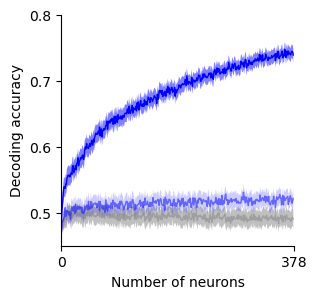

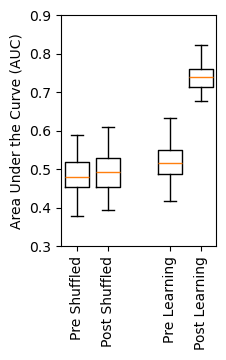

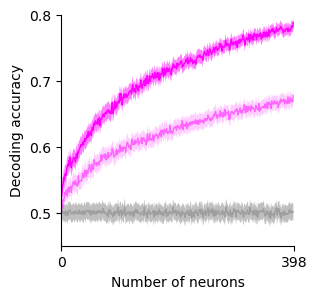

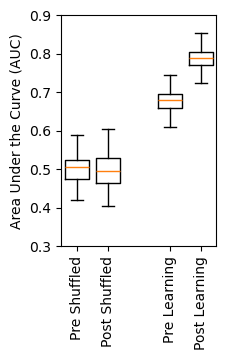

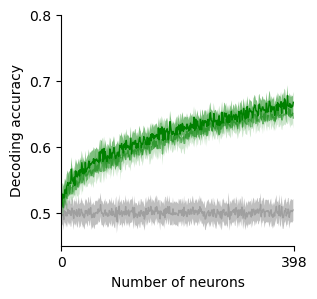

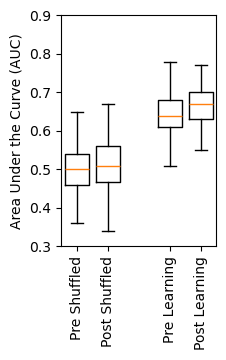

<Figure size 640x480 with 0 Axes>

In [4]:


# -------------------------------------------------------------------
# Script: Quantification & plotting of decoding accuracy
# Loads SVM decoding results (accuracy vs neuron count) and generates:
#   1. Line plots showing accuracy growth with neuron count
#   2. Boxplots comparing shuffled vs real accuracy
# -------------------------------------------------------------------

# Base working directory
cwd = os.getcwd()

# Folder containing saved decoding accuracy results (from previous script)
folderpath = os.path.join(cwd, 'Figure2DE')

# Brain areas to plot and their colors
areas = ['LA', 'BLA', 'PIR']
colors = ['blue', 'magenta', 'green']


# ---- Loop through each brain area ----
for a, area in enumerate(areas):

    # Build file paths for accuracy and shuffled results
    accuracypath = os.path.join(folderpath, f"experiment1_increasingneuroncount{area}_accuracy.npy")
    shuffledpath = os.path.join(folderpath, f"experiment1_increasingneuroncount{area}_accuracyshuffle.npy")

    # Skip the first two neuron counts (start at 2 neurons)
    accuracy = np.load(accuracypath)[2:,:,:,:]   # shape = [neurons × timebins × iterations × pre/post]
    shuffle  = np.load(shuffledpath)[2:,:,:,:]

    neuronnum = accuracy.shape[0]  # number of neuron counts included

    # ----------------------------------------------------------------
    # Compute mean decoding accuracy and SEM across iterations
    # Pre-learning (d4 = 0) and post-learning (d4 = 1)
    # ----------------------------------------------------------------
    accuracy_pre  = np.mean(accuracy[:, :, :, 0], axis=2)   # average over iterations
    accuracy_post = np.mean(accuracy[:, :, :, 1], axis=2)
    sem_pre       = stats.sem(accuracy[:, :, :, 0], axis=2)
    sem_post      = stats.sem(accuracy[:, :, :, 1], axis=2)

    shuffle_pre   = np.mean(shuffle[:, :, :, 0], axis=2)
    shuffle_post  = np.mean(shuffle[:, :, :, 1], axis=2)
    sem_shuffle_pre  = stats.sem(shuffle[:, :, :, 0], axis=2)
    sem_shuffle_post = stats.sem(shuffle[:, :, :, 1], axis=2)

    # ----------------------------------------------------------------
    # Compute mean accuracy in the "sensory window"
    # Here: timebins 10–20 (average across this range)
    # ----------------------------------------------------------------
    meanaccuracypre       = np.mean(accuracy_pre[:, 10:20], axis=1)
    meanaccuracysem_pre   = np.mean(sem_pre[:, 10:20], axis=1)
    meanaccuracy_post     = np.mean(accuracy_post[:, 10:20], axis=1)
    meanaccuracysem_post  = np.mean(sem_post[:, 10:20], axis=1)

    shufflemeanaccuracypre      = np.mean(shuffle_pre[:, 10:20], axis=1)
    shufflemeanaccuracysem_pre  = np.mean(sem_shuffle_pre[:, 10:20], axis=1)
    shufflemeanaccuracy_post    = np.mean(shuffle_post[:, 10:20], axis=1)
    shufflemeanaccuracysem_post = np.mean(sem_shuffle_post[:, 10:20], axis=1)

    # Combine shuffle pre/post into one "null distribution" for 2D
    allshufflemean = np.mean(np.vstack((shufflemeanaccuracypre,
                                        shufflemeanaccuracy_post)), axis=0)
    allshufflesem  = np.mean(np.vstack((shufflemeanaccuracysem_pre,
                                        shufflemeanaccuracysem_post)), axis=0)


    # ---- Plot: Accuracy vs number of neurons ----
    plt.close()
    fig, ax = plt.subplots(1, sharey=True, sharex=True, figsize=(3, 3))

    # Plot shuffled baseline
    ax.plot(allshufflemean, color='gray', alpha=0.5, lw=1)
    ax.fill_between(np.arange(neuronnum),
                    allshufflemean - allshufflesem,
                    allshufflemean + allshufflesem,
                    color='gray', alpha=0.5, edgecolor='none')

    # Plot pre-learning decoding (lighter color)
    ax.plot(meanaccuracypre, color=colors[a], alpha=0.5, lw=1)
    ax.fill_between(np.arange(neuronnum),
                    meanaccuracypre - meanaccuracysem_pre,
                    meanaccuracypre + meanaccuracysem_pre,
                    color=colors[a], edgecolor='none', alpha=0.2)

    # Plot post-learning decoding (stronger color)
    ax.plot(meanaccuracy_post, color=colors[a], lw=1)
    ax.fill_between(np.arange(neuronnum),
                    meanaccuracy_post - meanaccuracysem_post,
                    meanaccuracy_post + meanaccuracysem_post,
                    color=colors[a], edgecolor='none', alpha=0.5)

    # Axis labels and limits
    ax.set_xlabel('Number of neurons')
    ax.set_ylabel('Decoding accuracy')

    # Remove top/right borders for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylim([0.45, 0.8])
    ax.set_xlim([0, neuronnum])
    ax.set_yticks((0.5, 0.6, 0.7, 0.8))
    ax.set_xticks((0, neuronnum))

    # show inline
    plt.show()
    
    # Save figure
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(os.path.join(folderpath, f'quantification_{area}.svg'), format='svg')


    # ---- Boxplot: Accuracy distribution at max neuron count ----
    plt.close()
    fig, ax = plt.subplots(1, figsize=(2, 3))

    # For the final neuron count, compare shuffled vs real (pre/post)
    ax.boxplot([
        np.mean(shuffle[-1, 10:20, :, 0], axis=0),  # Pre shuffled
        np.mean(shuffle[-1, 10:20, :, 1], axis=0),  # Post shuffled
        np.mean(accuracy[-1, 10:20, :, 0], axis=0), # Pre learning
        np.mean(accuracy[-1, 10:20, :, 1], axis=0)  # Post learning
    ],
    positions=[1, 2, 4, 5], widths=0.75, showfliers=False)

    # Axis formatting
    ax.set_ylim(0.30, 0.9)
    ax.set_yticks((0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9))
    ax.set_ylabel('Area Under the Curve (AUC)')
    ax.set_xticks([1, 2, 4, 5])
    ax.set_xticklabels(['Pre Shuffled', 'Post Shuffled',
                        'Pre Learning', 'Post Learning'], rotation=90)

    # show inline
    plt.show()
    
    # Save figure
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(os.path.join(folderpath, f'quantification2_{area}.svg'), format='svg')


In [3]:
accuracypath

'C:\\Users\\Cristina\\Documents\\GitHub\\BLAPIRpaper\\Figure2DE\\experiment1LA_accuracy.npy'